# Triplet Loss

### Load VGG16 Model

In [1]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
import cv2 as cv
import numpy as np
import os

In [2]:
size = 224

In [3]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(size, size, 3))
gap = GlobalAveragePooling2D()(base_model.output)
model = Model(inputs=base_model.input, outputs=gap)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Triplet Loss Model

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [5]:
def create_triplet_loss_model(embedding_model, input_shape):
    anchor_input = layers.Input(shape=input_shape, name='anchor_input')
    positive_input = layers.Input(shape=input_shape, name='positive_input')
    negative_input = layers.Input(shape=input_shape, name='negative_input')

    # Get embeddings
    anchor_embedding = embedding_model(anchor_input)
    positive_embedding = embedding_model(positive_input)
    negative_embedding = embedding_model(negative_input)

    # Triplet loss function
    margin = 0.5
    positive_distance = tf.reduce_sum(tf.square(anchor_embedding - positive_embedding), axis=1)
    negative_distance = tf.reduce_sum(tf.square(anchor_embedding - negative_embedding), axis=1)
    loss = tf.maximum(0.0, positive_distance - negative_distance + margin)
    loss = tf.reduce_mean(loss)

    triplet_loss_model = models.Model(inputs=[anchor_input, positive_input, negative_input], outputs=loss)
    return triplet_loss_model

In [6]:
triplet_model = create_triplet_loss_model(model, input_shape=(size, size, 3))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
triplet_model.compile(optimizer=optimizer, loss='mean_squared_error')

In [7]:
triplet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 anchor_input (InputLayer)   [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 positive_input (InputLayer  [(None, 224, 224, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 negative_input (InputLayer  [(None, 224, 224, 3)]        0         []                            
 )                                                                                                
                                                                                            

### Read Images and separate into anchors, positives, and negatives

In [8]:
from google.colab import drive
import os

In [9]:
drive.mount('gdrive')

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


In [10]:
folder_path = "./gdrive/My Drive/ICDAR-2011-Split"

In [11]:
for file in os.listdir(folder_path):
  print(file)

validation
test
train
train_features_triplet_224.npy
train_names_triplet_224.npy
train_labels_triplet_224.npy
train_anchors_224.npy
train_positives_224.npy
train_negatives_224.npy
train_features_triplet_loss_224.npy
test_features_triplet_loss_224.npy
validation_features_triplet_loss_224.npy


In [12]:
train_folder = "./gdrive/My Drive/ICDAR-2011-Split/train"
test_folder = "./gdrive/My Drive/ICDAR-2011-Split/test"
validation_folder = "./gdrive/My Drive/ICDAR-2011-Split/validation"

In [13]:
def read_images(folder_path):
    features = []
    names = []
    labels = []
    signatures = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]

    for signature in signatures:
        signature_path = os.path.join(folder_path, signature)
        images = os.listdir(signature_path)

        batch_features = []
        batch_names = []
        batch_labels = []

        for image_name in images:
            image_path = os.path.join(signature_path, image_name)
            # Read dan pre-processing gambar
            img = cv.imread(image_path)
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = cv.resize(img, (size, size))
            img = np.array(preprocess_input(img))

            features.append(img)
            names.append(signature[:3])

            if signature.endswith("_forg"):
                labels.append(0)
            else:
                labels.append(1)

    features = np.array(features)
    names = np.array(names)
    labels = np.array(labels)

    return features, names, labels

In [14]:
# train_features, train_names, train_labels = read_images(train_folder)

In [15]:
train_features_triplet_path = "./gdrive/My Drive/ICDAR-2011-Split/train_features_triplet_224.npy"
train_names_triplet_path = "./gdrive/My Drive/ICDAR-2011-Split/train_names_triplet_224.npy"
train_labels_triplet_path = "./gdrive/My Drive/ICDAR-2011-Split/train_labels_triplet_224.npy"

In [16]:
# np.save(train_features_triplet_path, train_features)
# np.save(train_names_triplet_path, train_names)
# np.save(train_labels_triplet_path, train_labels)

In [17]:
train_features = np.load(train_features_triplet_path)
train_names = np.load(train_names_triplet_path)
train_labels = np.load(train_labels_triplet_path)

In [18]:
print(train_features.shape)
print(train_names.shape)
print(train_labels.shape)

(857, 224, 224, 3)
(857,)
(857,)


In [19]:
unique_names = set(train_names)
sorted_names = sorted(unique_names)

In [20]:
print(sorted_names)

['001', '002', '003', '004', '006', '009', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069']


In [21]:
def split_positive_negative(features, names, labels, sorted_names):
    anchors = []
    positives = []
    negatives = []

    for name in sorted_names:
        indices = np.where(names == name)[0]
        positive_set, negative_set = [], []

        for index in indices:
            # print(labels[index])
            if labels[index] == 0:
                negative_set.append(features[index])
            else:
                positive_set.append(features[index])

        negative_set = np.array(negative_set)
        positive_set = np.array(positive_set)

        anchor = positive_set[0]
        positive_set = positive_set[1:]

        anchor_set = []
        if(len(positive_set) < len(negative_set)):
            positive_idx = np.random.choice(len(positive_set), size=len(negative_set), replace=True)
            positive = positive_set[positive_idx]
            negative = negative_set
            for _ in range(0, len(negative_set)):
                anchor_set.append(anchor)
        elif(len(positive_set) > len(negative_set)):
            negative_idx = np.random.choice(len(negative_set), size=len(positive_set), replace=True)
            negative = negative_set[negative_idx]
            positive = positive_set
            for _ in range(0, len(positive_set)):
                anchor_set.append(anchor)
        else:
            positive = positive_set
            negative = negative_set
            for _ in range(0, len(negative_set)):
                anchor_set.append(anchor)

        anchors.append(anchor_set)
        positives.append(positive)
        negatives.append(negative)

    anchors = np.concatenate(anchors)
    positives = np.concatenate(positives)
    negatives = np.concatenate(negatives)

    return anchors, positives, negatives

In [22]:
# train_anchors, train_positives, train_negatives = split_positive_negative(train_features, train_names, train_labels, sorted_names)

In [23]:
train_anchors_path = "./gdrive/My Drive/ICDAR-2011-Split/train_anchors_224.npy"
train_positives_path = "./gdrive/My Drive/ICDAR-2011-Split/train_positives_224.npy"
train_negatives_path = "./gdrive/My Drive/ICDAR-2011-Split/train_negatives_224.npy"

In [24]:
# np.save(train_anchors_path, train_anchors)
# np.save(train_positives_path, train_positives)
# np.save(train_negatives_path, train_negatives)

In [25]:
train_anchors = np.load(train_anchors_path)
train_positives = np.load(train_positives_path)
train_negatives = np.load(train_negatives_path)

In [26]:
print(train_anchors.shape)
print(train_positives.shape)
print(train_negatives.shape)

(472, 224, 224, 3)
(472, 224, 224, 3)
(472, 224, 224, 3)


In [27]:
history = triplet_model.fit([train_anchors, train_positives, train_negatives], np.zeros_like(train_anchors), epochs=2, batch_size=32)

Epoch 1/2
15/15 [==============================] - 75s 3s/step - loss: 34.5913
Epoch 2/2
15/15 [==============================] - 19s 1s/step - loss: 0.2517


In [28]:
import matplotlib.pyplot as plt

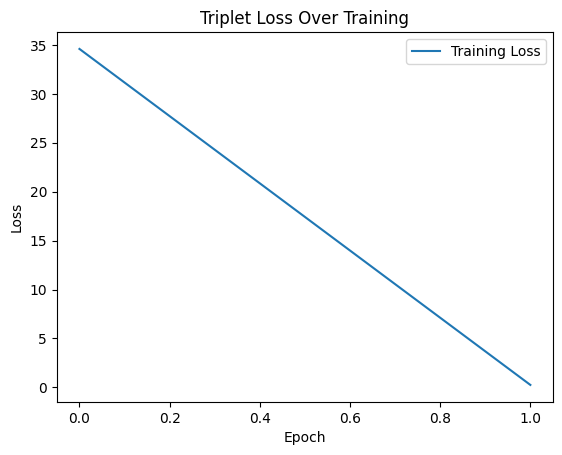

In [29]:
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Triplet Loss Over Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Feature Extraction

In [30]:
def extract_features(folder_path, batch_size=32):
    features = []
    names = []
    labels = []
    signatures = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]

    for signature in signatures:
        signature_path = os.path.join(folder_path, signature)
        images = os.listdir(signature_path)

        batch_features = []
        batch_names = []
        batch_labels = []

        for image_name in images:
            image_path = os.path.join(signature_path, image_name)
            # Read dan pre-processing gambar
            img = cv.imread(image_path)
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = cv.resize(img, (size, size))
            img = np.array(preprocess_input(img))

            batch_features.append(img)
            batch_names.append(signature[:3])

            if signature.endswith("_forg"):
                batch_labels.append(0)
            else:
                batch_labels.append(1)

            if len(batch_features) == batch_size:
                batch_features = np.array(batch_features)
                batch_features = model.predict(batch_features)
                batch_features = batch_features.reshape(len(batch_features), -1)

                features.extend(batch_features)
                names.extend(batch_names)
                labels.extend(batch_labels)

                batch_features = []
                batch_names = []
                batch_labels = []

        if batch_features:
            batch_features = np.array(batch_features)
            batch_features = model.predict(batch_features)
            batch_features = batch_features.reshape(len(batch_features), -1)

            features.extend(batch_features)
            names.extend(batch_names)
            labels.extend(batch_labels)

    return features, names, labels

In [39]:
print(os.listdir(train_folder))

['001', '001_forg', '002_forg', '002', '006', '003_forg', '012', '003', '012_forg', '004', '009', '006_forg', '004_forg', '009_forg', '013', '015_forg', '016_forg', '015', '014_forg', '014', '017_forg', '013_forg', '017', '016', '018', '022_forg', '022', '021_forg', '020_forg', '021', '019_forg', '019', '020', '018_forg', '024', '025', '027_forg', '024_forg', '025_forg', '026', '027', '023', '023_forg', '026_forg', '030_forg', '028_forg', '029_forg', '029', '031_forg', '032', '028', '032_forg', '031', '030', '037_forg', '035_forg', '036', '034_forg', '035', '033_forg', '033', '034', '037', '036_forg', '042', '040', '039', '038', '038_forg', '041', '041_forg', '040_forg', '039_forg', '042_forg', '047', '046', '043_forg', '047_forg', '044_forg', '044', '045_forg', '043', '045', '046_forg', '051', '052_forg', '051_forg', '050', '049_forg', '048', '048_forg', '049', '052', '050_forg', '053', '054_forg', '053_forg', '056_forg', '056', '055_forg', '057_forg', '055', '054', '057', '061', '061

In [31]:
train_features_new, _, _ = extract_features(train_folder)
test_features, _, _ = extract_features(test_folder)
validation_features, _, _ = extract_features(validation_folder)

1/1 [==============================] - 0s 20ms/step


In [32]:
print(len(train_features_new), len(train_features_new[0]))
print(len(test_features), len(test_features[0]))
print(len(validation_features), len(validation_features[0]))

857 512
401 512
391 512


In [33]:
print(train_features_new)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Save and Load Features, Names, and Labels to reduce time needed

In [34]:
train_features_path =  "./gdrive/My Drive/ICDAR-2011-Split/train_features_triplet_loss_224.npy"
test_features_path = "./gdrive/My Drive/ICDAR-2011-Split/test_features_triplet_loss_224.npy"
validation_features_path = "./gdrive/My Drive/ICDAR-2011-Split/validation_features_triplet_loss_224.npy"

In [35]:
np.save(train_features_path, train_features_new)
np.save(validation_features_path, validation_features)
np.save(test_features_path, test_features)